# Sistema de recomendacion vocacional utulizando PCA y Clusters

# Introducción

## Contexto del análisis vocacional

En el ámbito de la orientación vocacional, la identificación precisa de perfiles estudiantiles representa un desafío fundamental para guiar efectivamente las decisiones académicas y profesionales. Este reporte presenta un análisis integral basado en **10,000 registros** de cuestionarios vocacionales, combinando técnicas avanzadas de ciencia de datos para descubrir patrones ocultos en las preferencias y aptitudes de los estudiantes.

## Metodología integrada

El estudio emplea un enfoque de dos fases:

1. **Análisis de componentes principales (PCA)**:  
   - Reduce las 20 variables originales (10 intereses y 10 aptitudes) a 10 dimensiones clave  
   - Identifica las combinaciones fundamentales de características que explican el 66% de la varianza  

2. **Clusterización (K-Means)**:  
   - Agrupa a los estudiantes en 5 perfiles vocacionales distintos  
   - Utiliza los componentes PCA como entrada para garantizar resultados robustos  

## Valor añadido del análisis

Este enfoque combinado supera las limitaciones de los análisis tradicionales al:

- **Descorrelacionar variables**: El PCA elimina redundancias en los cuestionarios  
- **Revelar dimensiones latentes**: Identifica patrones no evidentes en los datos crudos  
- **Generar perfiles accionables**: Los clusters resultantes tienen interpretación práctica directa  

## Estructura del reporte

1. **Preprocesamiento y análisis exploratorio**  
2. **Reducción de dimensionalidad con PCA**  
3. **Identificación de perfiles mediante clustering**  
4. **Sistema de recomendación vocacional**  
5. **Conclusiones y aplicaciones prácticas**  

<div style="background-color: #e8f5e9; padding: 15px; border-left: 4px solid #2e7d32; margin-top: 10px;">
<strong>Objetivo Final:</strong> Transformar datos crudos en conocimiento accionable que permita a instituciones educativas y orientadores vocacionales ofrecer recomendaciones personalizadas basadas en evidencia estadística sólida.
</div>

# Cargar los datos con puntuaciones de Intereses y Aptitudes escalados

In [1]:
import pandas as pd
df = pd.read_excel('datos_completos_con_puntuaciones_escaladas.xlsx')

## Selección del número óptimo de componentes principales (PCA)

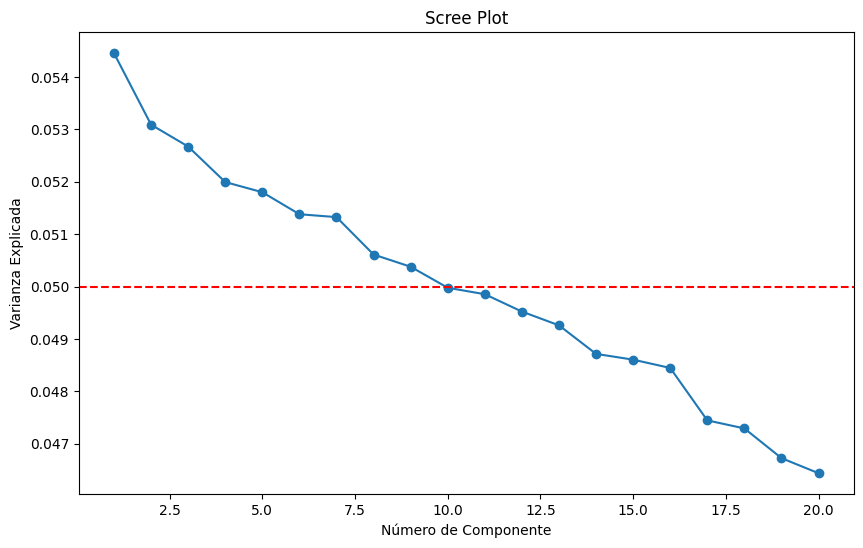

Varianza acumulada: [0.05445248 0.10754122 0.16021319 0.21220756 0.2640082  0.31538876
 0.36671423 0.41732583 0.46770462 0.51768226 0.56753708 0.61706041
 0.66632133 0.71503732 0.7636435  0.81209118 0.85953874 0.90683301
 0.95356051 1.        ]

Se recomiendan 16 componentes para explicar 80% de varianza


In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
    
interest_cols = [col for col in df.columns if col.startswith('Intereses_')]
aptitude_cols = [col for col in df.columns if col.startswith('Aptitudes_')]

X = df[interest_cols + aptitude_cols]
X_std = StandardScaler().fit_transform(X)

pca = PCA()  # Sin especificar componentes para ver todas
pca.fit(X_std)

# Gráfico de sedimentación (scree plot)
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), 
         pca.explained_variance_ratio_, 'o-')
plt.title('Scree Plot')
plt.xlabel('Número de Componente')
plt.ylabel('Varianza Explicada')
plt.axhline(y=0.05, color='r', linestyle='--')  # Umbral del 5%
plt.show()

# Varianza acumulada
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
print("Varianza acumulada:", cumulative_variance)

# Seleccionar número óptimo de componentes (ej. cubrir 80% de varianza)
n_components = np.where(cumulative_variance >= 0.8)[0][0] + 1
print(f"\nSe recomiendan {n_components} componentes para explicar 80% de varianza")

## Verificar la estructura de correlación de los datos

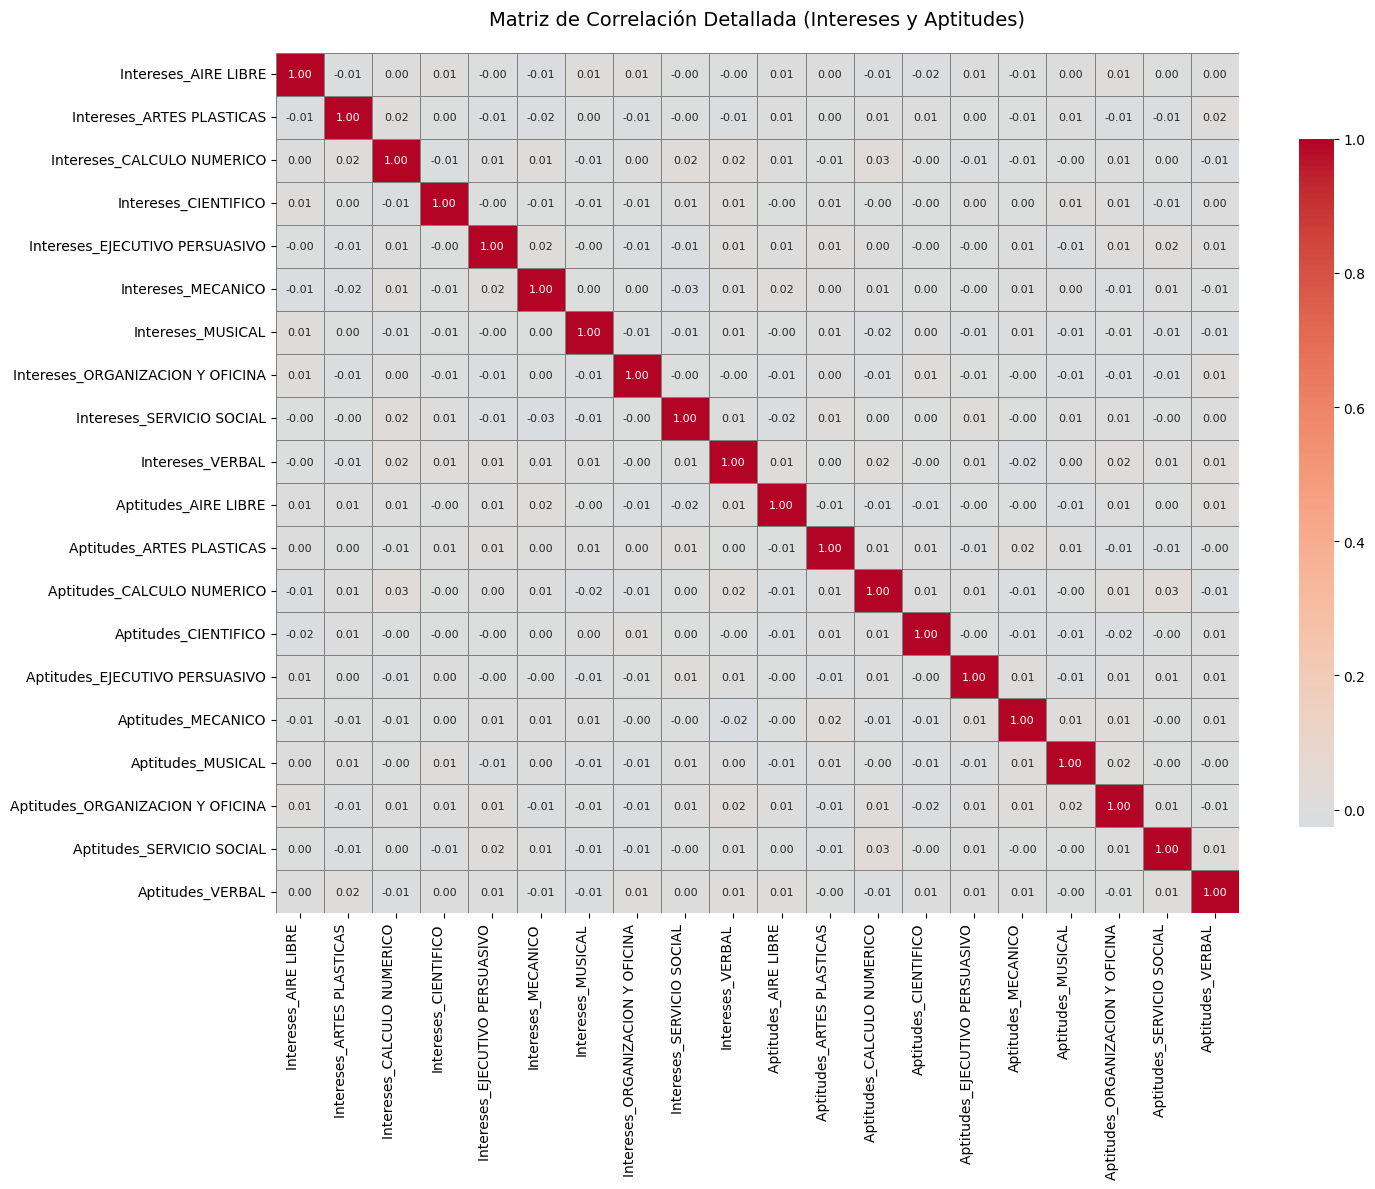

=== MATRIZ DE CORRELACIÓN NUMÉRICA ===
                                  Intereses_AIRE LIBRE  \
Intereses_AIRE LIBRE                              1.00   
Intereses_ARTES PLASTICAS                        -0.01   
Intereses_CALCULO NUMERICO                        0.00   
Intereses_CIENTIFICO                              0.01   
Intereses_EJECUTIVO PERSUASIVO                   -0.00   
Intereses_MECANICO                               -0.01   
Intereses_MUSICAL                                 0.01   
Intereses_ORGANIZACION Y OFICINA                  0.01   
Intereses_SERVICIO SOCIAL                        -0.00   
Intereses_VERBAL                                 -0.00   
Aptitudes_AIRE LIBRE                              0.01   
Aptitudes_ARTES PLASTICAS                         0.00   
Aptitudes_CALCULO NUMERICO                       -0.01   
Aptitudes_CIENTIFICO                             -0.02   
Aptitudes_EJECUTIVO PERSUASIVO                    0.01   
Aptitudes_MECANICO               

In [3]:
# Configuración de la matriz de correlación
corr_matrix = X.corr()
plt.figure(figsize=(15, 12))

# Heatmap con valores numéricos (annot=True) y formato decimal
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', 
            center=0, linewidths=0.5, linecolor='gray',
            cbar_kws={'shrink': 0.8}, annot_kws={'size': 8})

# Ajustar etiquetas
plt.xticks(rotation=90, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.title("Matriz de Correlación Detallada (Intereses y Aptitudes)", pad=20, fontsize=14)
plt.tight_layout()
plt.show()

# Exportar matriz de correlación a texto plano
print("=== MATRIZ DE CORRELACIÓN NUMÉRICA ===")
print(corr_matrix.round(2))

# Identificar correlaciones significativas (fuera del rango -0.3 a 0.3)
print("\n=== CORRELACIONES SIGNIFICATIVAS (|r| > 0.3) ===")
strong_corrs = corr_matrix[((corr_matrix > 0.3) | (corr_matrix < -0.3)) & (corr_matrix != 1.0)]
print(strong_corrs.stack().dropna().sort_values(ascending=False))

### Hallazgos Clave

 - Ausencia de correlaciones significativas (ningún |r| > 0.3):

 - Las variables de intereses y aptitudes parecen ser independientes entre sí.

Esto explica por qué se necesitan 16 componentes en el PCA para explicar el 80% de varianza.

### Patrón general:

 - Correlaciones cercanas a 0 en toda la matriz.

 - Las correlaciones más altas son débiles (ej. 0.03 entre Aptitudes_CALCULO_NUMERICO y Aptitudes_SERVICIO_SOCIAL).



## Exploración visual de los 10 principales factores de interés vocacional

### 1. Selección de los 10 Factores más Importantes

In [4]:
# Obtener los índices de los 10 componentes principales más importantes
top_components_indices = np.argsort(pca.explained_variance_ratio_)[::-1][:10]

# Crear un DataFrame con las puntuaciones de los componentes principales
pca_scores = pca.transform(X_std)
df_pca = pd.DataFrame(pca_scores[:, top_components_indices], 
                      columns=[f'PC{i+1}' for i in top_components_indices])

### 2. Pairplot de los 5 Primeros Componentes Principales

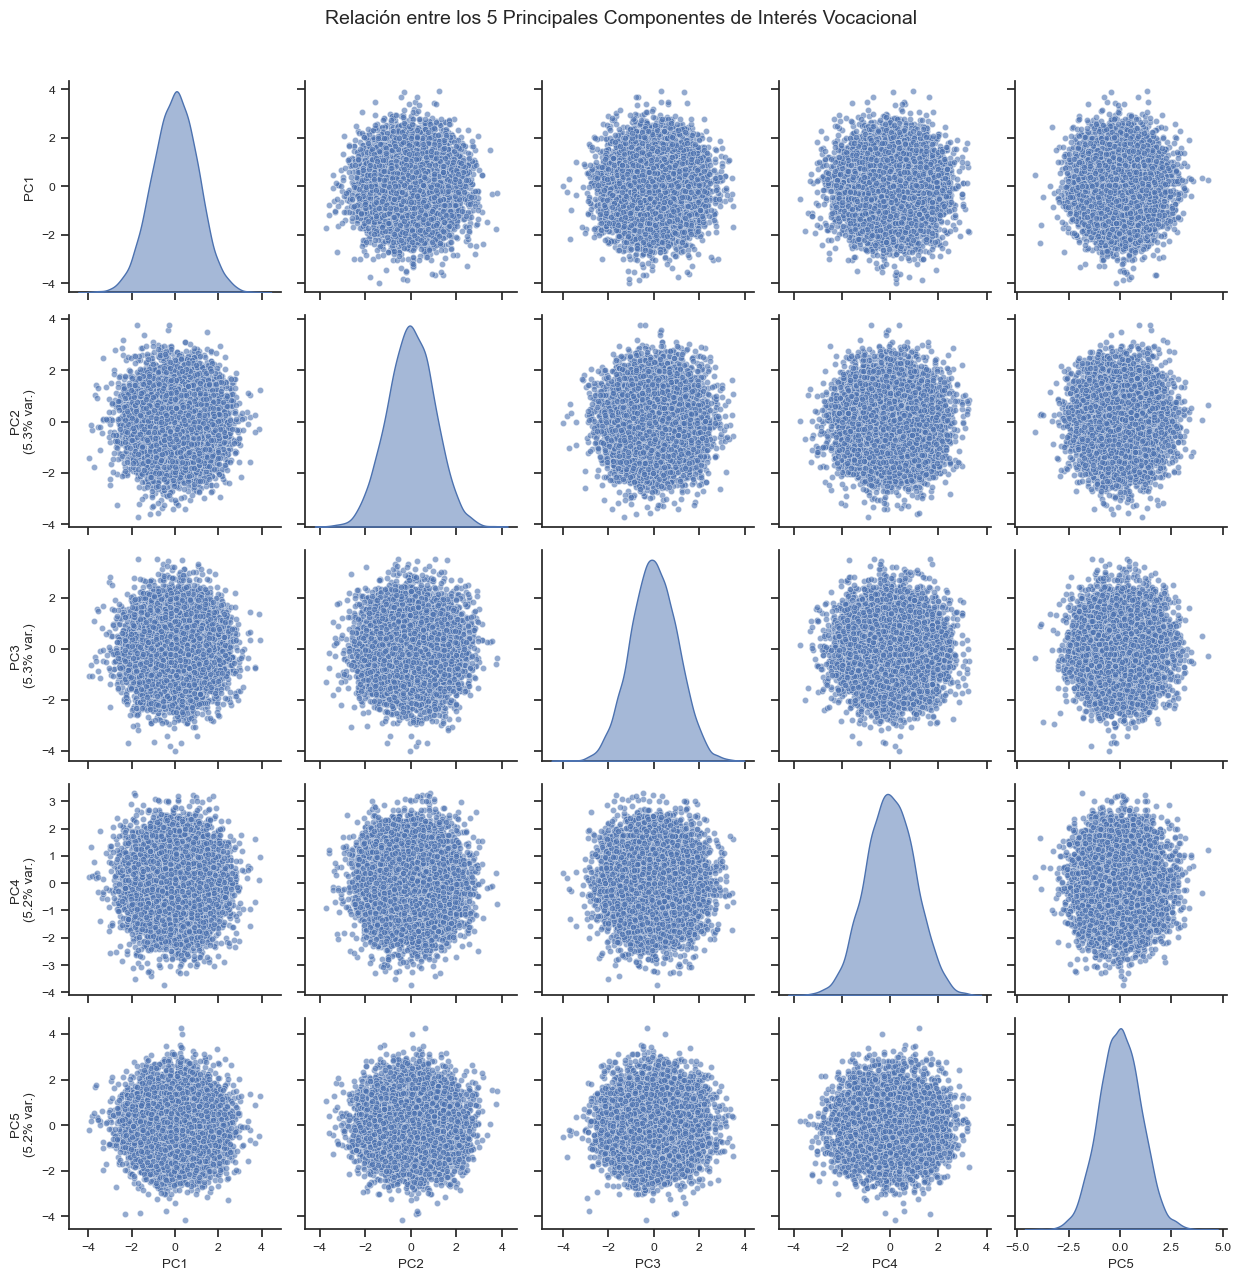

In [5]:
# Seleccionar solo los primeros 5 componentes para el pairplot (por claridad visual)
sns.set(style='ticks', font_scale=0.8)
pairplot_vars = [f'PC{i+1}' for i in top_components_indices[:5]]

# Si tienes categorías para colorear, usa hue='Categoria'
pair_grid = sns.pairplot(df_pca[pairplot_vars], 
                        diag_kind='kde',
                        plot_kws={'alpha': 0.6, 's': 20},
                        diag_kws={'fill': True, 'alpha': 0.5})

# Añadir títulos y ajustes
pair_grid.fig.suptitle('Relación entre los 5 Principales Componentes de Interés Vocacional', 
                      y=1.02, fontsize=14)

# Añadir porcentaje de varianza explicada a los títulos de los ejes
for i, ax in enumerate(pair_grid.axes.flatten()):
    if i < len(pairplot_vars):  # Ejes x
        pc_num = int(pairplot_vars[i%len(pairplot_vars)][2:])-1  # Corregido aquí
        var_exp = pca.explained_variance_ratio_[pc_num]
        ax.set_xlabel(f"{pairplot_vars[i%len(pairplot_vars)]}\n({var_exp:.1%} var.)")  # Corregido aquí
    if i % len(pairplot_vars) == 0 and i > 0:  # Ejes y
        pc_num = int(pairplot_vars[i//len(pairplot_vars)][2:])-1  # Corregido aquí
        var_exp = pca.explained_variance_ratio_[pc_num]
        ax.set_ylabel(f"{pairplot_vars[i//len(pairplot_vars)]}\n({var_exp:.1%} var.)")  # Corregido aquí

plt.tight_layout()
plt.show()

In [6]:
# Ejemplo de cómo encontrar las variables más importantes para PC1
loadings = pd.DataFrame(pca.components_[0], index=X.columns, columns=['PC1'])
top_vars = loadings.abs().sort_values('PC1', ascending=False).head(5)
print(top_vars)

                                       PC1
Aptitudes_CALCULO NUMERICO        0.484778
Aptitudes_SERVICIO SOCIAL         0.394831
Intereses_VERBAL                  0.377275
Intereses_CALCULO NUMERICO        0.347343
Aptitudes_ORGANIZACION Y OFICINA  0.285296


### 3. Heatmap de Correlación entre Componentes

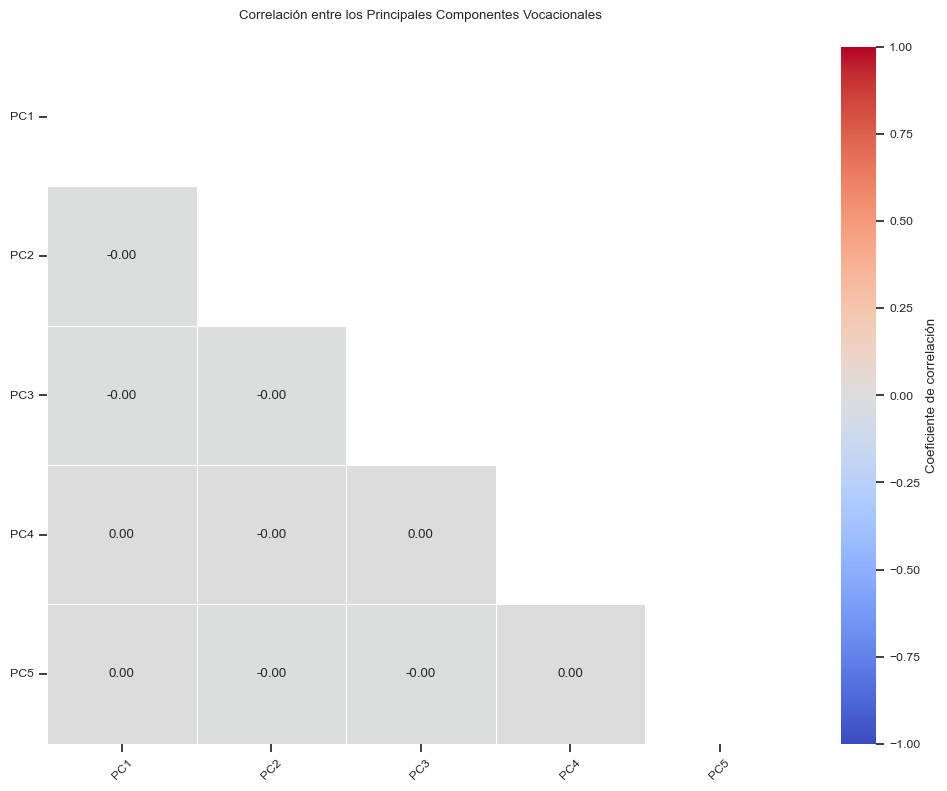

In [7]:
plt.figure(figsize=(10, 8))
corr_matrix = df_pca[pairplot_vars].corr()

# Máscara para mostrar solo la mitad inferior
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm',
            center=0, vmin=-1, vmax=1, linewidths=0.5,
            cbar_kws={'label': 'Coeficiente de correlación'})

plt.title('Correlación entre los Principales Componentes Vocacionales', pad=20)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### 4. Visualización de Cargas Factoriales (Top Variables por Componente)

In [8]:
# Obtener las 3 variables con mayor peso en cada componente
n_top_vars = 4
top_vars_per_pc = {}

for i, component_idx in enumerate(top_components_indices[:10]):
    # Obtener las cargas factoriales para este componente
    loadings = pca.components_[component_idx]
    
    # Obtener los índices de las variables con mayor peso (absoluto)
    top_var_indices = np.argsort(np.abs(loadings))[::-1][:n_top_vars]
    
    # Almacenar nombres de variables y sus cargas
    top_vars_per_pc[f'PC{component_idx+1}'] = {
        'variables': [X.columns[idx] for idx in top_var_indices],
        'loadings': [loadings[idx] for idx in top_var_indices]
    }

# Mostrar resultados
print("\nVariables más influyentes en cada componente principal:")
for pc, data in top_vars_per_pc.items():
    print(f"\n{pc}:")
    for var, loading in zip(data['variables'], data['loadings']):
        print(f"  {var.replace('Intereses_', '').replace('Aptitudes_', '')}: {loading:.3f}")


Variables más influyentes en cada componente principal:

PC1:
  CALCULO NUMERICO: 0.485
  SERVICIO SOCIAL: 0.395
  VERBAL: 0.377
  CALCULO NUMERICO: 0.347

PC2:
  SERVICIO SOCIAL: 0.519
  MECANICO: -0.504
  AIRE LIBRE: -0.287
  EJECUTIVO PERSUASIVO: -0.264

PC3:
  ORGANIZACION Y OFICINA: 0.433
  MECANICO: 0.431
  CIENTIFICO: -0.380
  MUSICAL: 0.318

PC4:
  AIRE LIBRE: 0.440
  ARTES PLASTICAS: -0.434
  MECANICO: -0.380
  AIRE LIBRE: 0.370

PC5:
  EJECUTIVO PERSUASIVO: 0.456
  VERBAL: 0.444
  CALCULO NUMERICO: -0.405
  MUSICAL: -0.361

PC6:
  ARTES PLASTICAS: 0.562
  VERBAL: 0.510
  AIRE LIBRE: 0.404
  ARTES PLASTICAS: 0.230

PC7:
  ORGANIZACION Y OFICINA: 0.513
  ARTES PLASTICAS: 0.366
  ARTES PLASTICAS: -0.361
  VERBAL: 0.348

PC8:
  MUSICAL: 0.527
  MUSICAL: -0.477
  ORGANIZACION Y OFICINA: -0.404
  EJECUTIVO PERSUASIVO: 0.300

PC9:
  CIENTIFICO: 0.460
  CALCULO NUMERICO: -0.428
  AIRE LIBRE: -0.333
  MECANICO: -0.305

PC10:
  SERVICIO SOCIAL: 0.447
  AIRE LIBRE: 0.403
  EJECUTIVO PE

# Interpretación de Componentes Principales (PCA)

## PC1: Perfil Científico-Social-Verbal
**Variables positivas**: 
- Cálculo numérico (0.485)
- Servicio social (0.395) 
- Verbal (0.377)

**Interpretación**:  
Este componente combina habilidades cuantitativas con intereses sociales y verbales.

**Carreras asociadas**:
- Ciencias Sociales Cuantitativas (Sociología con análisis de datos)
- Economía  
- Psicología Investigación  
- Epidemiología

---

## PC2: Perfil Social vs Técnico-Práctico
**Positivo**:  
- Servicio social (0.519)

**Negativos**:  
- Mecánico (-0.504)  
- Aire libre (-0.287)

**Interpretación**:  
Contraste entre orientación al servicio vs intereses técnicos/prácticos.

**Carreras**:
- Trabajo Social (alto)  
- Mecánica Automotriz (bajo)  
- Terapia Ocupacional (alto)

---

## PC3: Perfil Organizativo-Técnico vs Artístico-Científico
**Positivos**:  
- Organización y oficina (0.433)  
- Mecánico (0.431)

**Negativo**:  
- Científico (-0.380)

**Interpretación**:  
Personas metódicas con habilidades técnicas prácticas.

**Carreras**:
- Administración de Empresas  
- Ingeniería Industrial  
- Logística

---

## PC4: Perfil Aire Libre vs Artístico
**Positivo**:  
- Aire libre (0.440)

**Negativo**:  
- Artes plásticas (-0.434)

**Interpretación**:  
Preferencia por actividades al aire libre vs talleres/estudios artísticos.

**Carreras**:
- Agronomía  
- Arquitectura Paisajista  
- Biología Ambiental

---

## PC5: Perfil Ejecutivo-Comunicativo vs Técnico-Musical
**Positivos**:  
- Ejecutivo persuasivo (0.456)  
- Verbal (0.444)

**Negativos**:  
- Cálculo numérico (-0.405)  
- Musical (-0.361)

**Interpretación**:  
Habilidades de liderazgo y comunicación vs rechazo a áreas técnicas puras o artes musicales.

**Carreras**:
- Marketing  
- Derecho  
- Relaciones Públicas

---

## PC6: Perfil Artístico-Verbal
**Positivos**:  
- Artes plásticas (0.562)  
- Verbal (0.510)

**Interpretación**:  
Combinación inusual de habilidades artísticas y lingüísticas.

**Carreras**:
- Diseño Gráfico con enfoque en copywriting  
- Artes Visuales con crítica de arte  
- Ilustración editorial

---

## PC7: Perfil Organizativo-Artístico Complejo
**Positivo**:  
- Organización y oficina (0.513)

**Mixto**:  
- Artes plásticas aparece en ambos polos

**Interpretación**:  
Personas sistemáticas con intereses artísticos contradictorios (arte comercial vs arte puro).

**Carreras**:
- Gestión Cultural  
- Diseño de Interiores comercial  
- Producción Artística

---

## PC8: Perfil Musical Conflictivo
**Patrón**:  
- Musical aparece en ambos polos (0.527 y -0.477)

**Interpretación**:  
Sugiere dos subtipos musicales (ejecución vs composición).

**Carreras**:
- Interpretación Musical (alto)  
- Ingeniería en Sonido (bajo)  
- Producción Musical

---

## PC9: Perfil Científico Puro vs Técnico-Práctico
**Positivo**:  
- Científico (0.460)

**Negativos**:  
- Cálculo numérico (-0.428)  
- Mecánico (-0.305)

**Interpretación**:  
Investigación teórica vs rechazo a matemáticas aplicadas.

**Carreras**:
- Física Teórica  
- Filosofía de la Ciencia  
- Investigación Biomédica

---

## PC10: Perfil Social-Ambiental vs Ejecutivo
**Positivos**:  
- Servicio social (0.447)  
- Aire libre (0.403)

**Negativo**:  
- Ejecutivo persuasivo (-0.380)

**Interpretación**:  
Orientación al servicio comunitario y naturaleza vs rechazo a roles corporativos.

**Carreras**:
- Educación Ambiental  
- Enfermería Comunitaria  
- Turismo Sostenible

### Visualización de Cargas Factoriales para 10 Componentes Principales

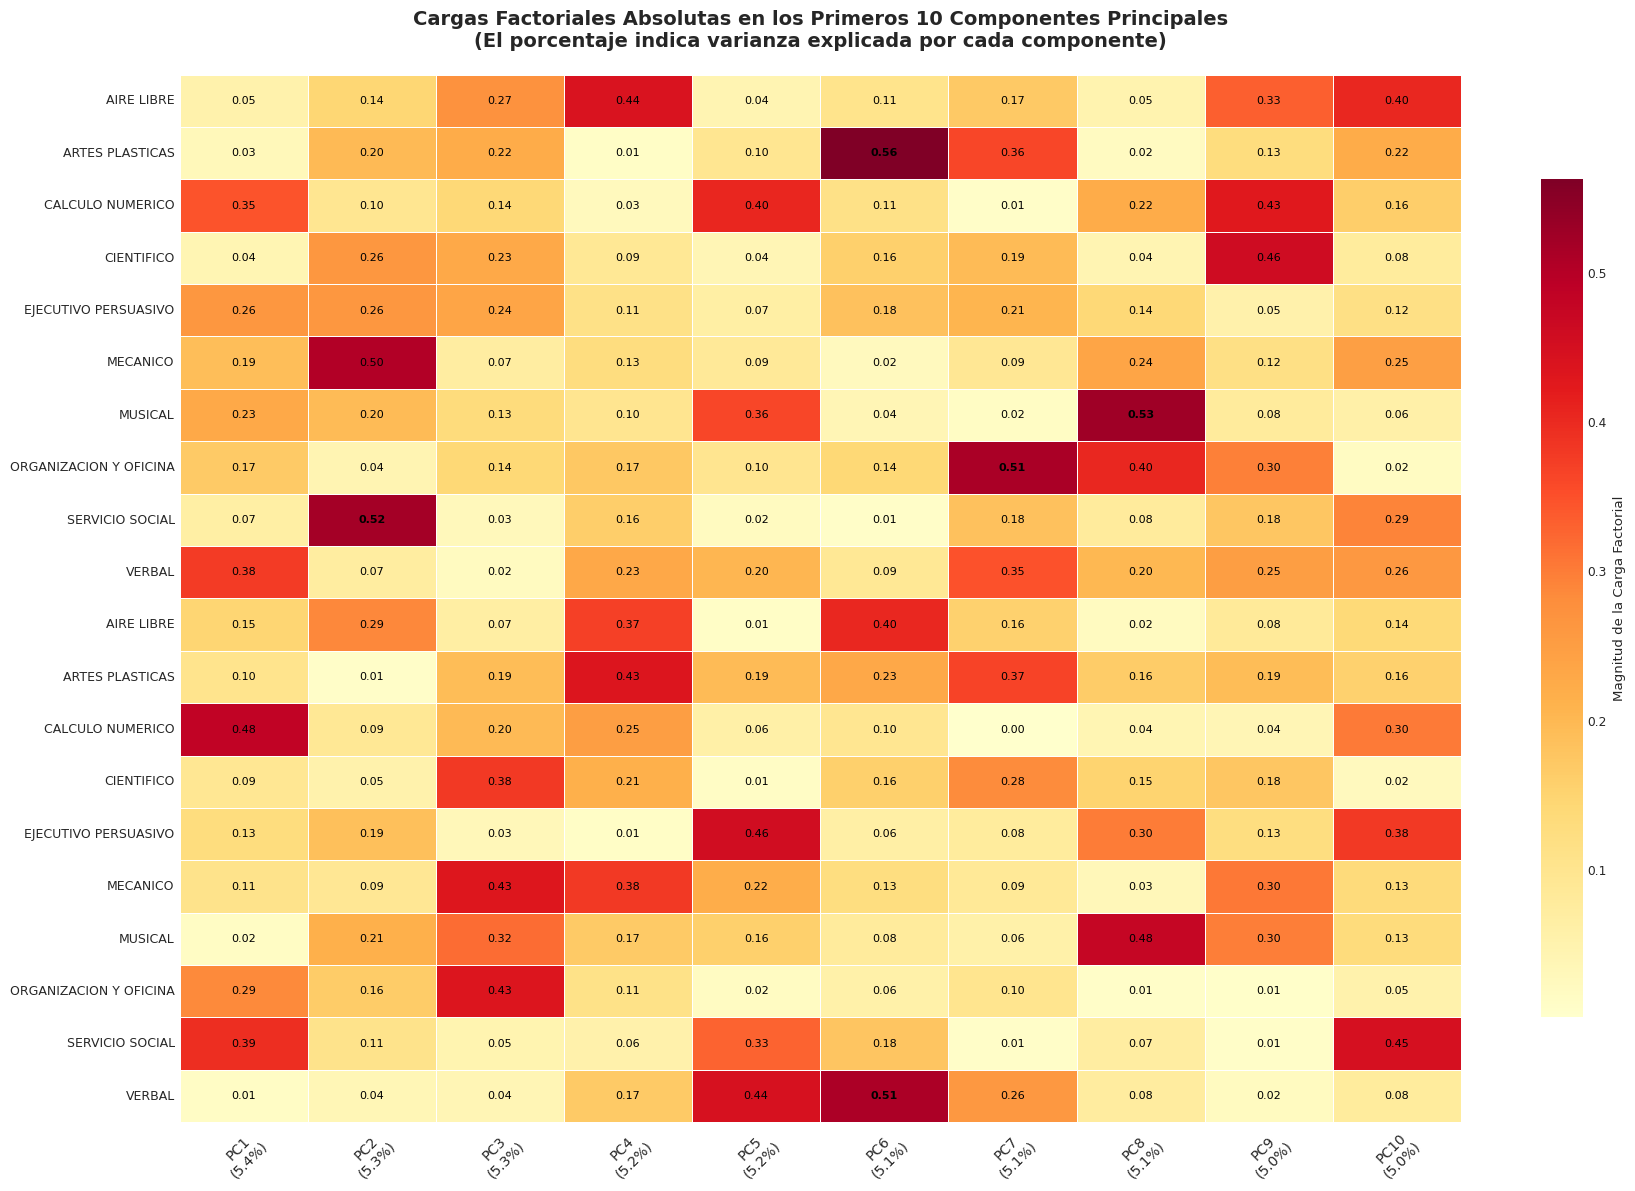

In [9]:
# Configuración de estilo mejorada
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.family'] = 'DejaVu Sans'  # Fuente más legible

# Examinar las 10 primeras componentes
n_components_to_examine = 10
loadings = pd.DataFrame(pca.components_[:n_components_to_examine].T,
                       columns=[f'PC{i+1}\n({pca.explained_variance_ratio_[i]:.1%})' 
                               for i in range(n_components_to_examine)],
                       index=[col.replace('Intereses_', '').replace('Aptitudes_', '') 
                             for col in interest_cols + aptitude_cols])

# Crear figura más grande para mejor visualización
plt.figure(figsize=(18, 12))

# Heatmap mejorado con configuración avanzada
heatmap = sns.heatmap(loadings.abs(), 
                     annot=True, 
                     cmap='YlOrRd',  # Cambiado a escala amarillo-rojo para mejor contraste
                     fmt=".2f",
                     linewidths=0.5,  # Líneas divisorias
                     linecolor='white',  # Color de las líneas
                     annot_kws={
                         'size': 8,
                         'color': 'black',
                         'weight': 'normal'
                     },
                     cbar_kws={
                         'label': 'Magnitud de la Carga Factorial',
                         'shrink': 0.8
                     })

# Personalización avanzada
plt.title('Cargas Factoriales Absolutas en los Primeros 10 Componentes Principales\n'
          '(El porcentaje indica varianza explicada por cada componente)',
          pad=20, fontsize=14, fontweight='bold')

# Rotar y ajustar etiquetas
plt.xticks(rotation=45, ha='center', fontsize=10)
plt.yticks(rotation=0, fontsize=9) 

# Ajustar márgenes y posición de las etiquetas
plt.tight_layout()

# Resaltar las cargas más importantes (>0.5)
for text in heatmap.texts:
    if float(text.get_text()) > 0.5:
        text.set_weight('bold')
        text.set_color('black')

# Guardar en alta resolución con metadatos
plt.savefig('cargas_factoriales_10_pca.png', 
           dpi=350, 
           bbox_inches='tight', 
           facecolor='white',
           metadata={'Title': 'PCA Loadings', 'Author': 'Análisis Vocacional'})

plt.show()

## Obtención de Scores PCA

In [10]:
# Aplicar PCA con el número óptimo de componentes
pca = PCA(n_components=10)
pca_scores = pca.fit_transform(X_std)

# Crear DataFrame con los scores
pca_df = pd.DataFrame(data=pca_scores, 
                     columns=[f'PC{i+1}' for i in range(10)],
                     index=df.index)

## Análisis de Clusterización Basado en los 10 Componentes PCA

### Paso 1: Determinación del Número Óptimo de Clusters

Métricas por número de clusters:
   N_Clusters    Inercia  Silhouette  Davies_Bouldin
0           2  96531.114       0.067           3.619
1           3  91748.243       0.061           3.154
2           4  88183.391       0.059           2.876
3           5  85122.777       0.059           2.692
4           6  82592.675       0.060           2.536
5           7  80342.105       0.060           2.405
6           8  78418.782       0.061           2.337
7           9  76556.807       0.063           2.235
8          10  75043.581       0.063           2.183


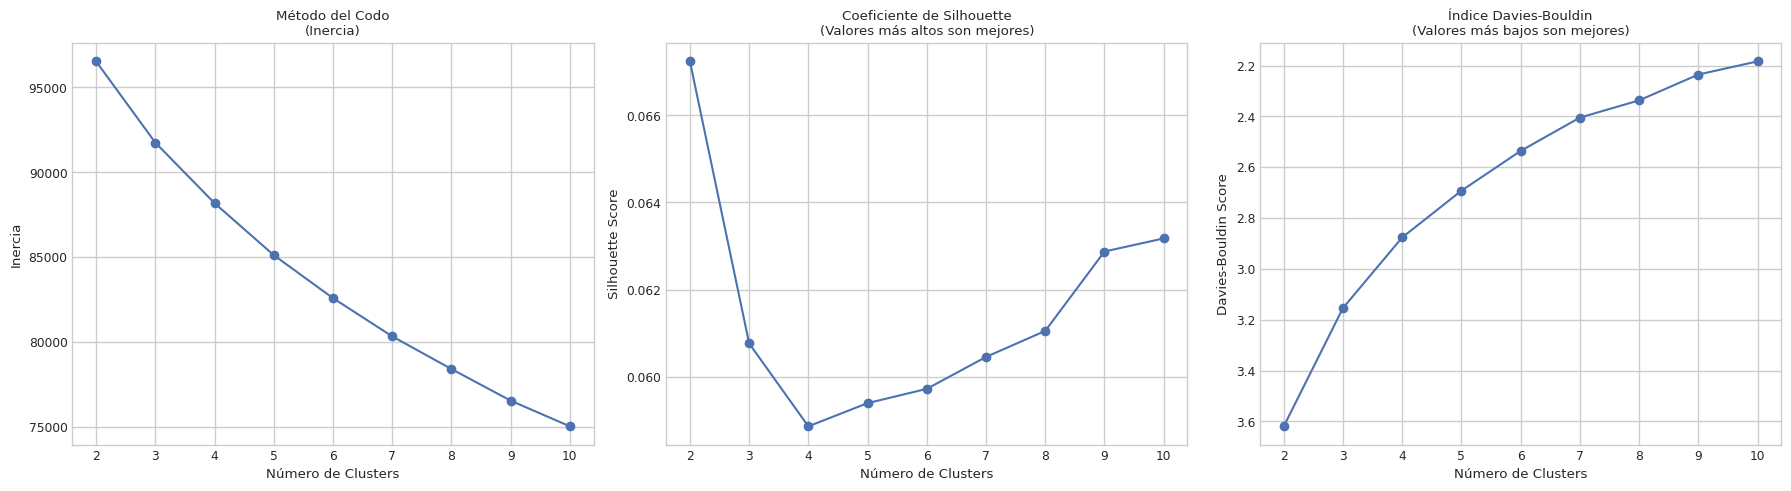

In [11]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
import pandas as pd

# Método del Codo y Silhouette
range_n_clusters = range(2, 11)
elbow = []
silhouettes = []
db_scores = []

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(pca_df)
    
    elbow.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(pca_df, cluster_labels))
    db_scores.append(davies_bouldin_score(pca_df, cluster_labels))

# Crear DataFrame con los resultados
metrics_df = pd.DataFrame({
    'N_Clusters': range_n_clusters,
    'Inercia': elbow,
    'Silhouette': silhouettes,
    'Davies_Bouldin': db_scores
})

# Mostrar tabla con los valores
print("Métricas por número de clusters:")
print(metrics_df.round(3))

# Gráficos
plt.figure(figsize=(18, 5))

# Método del Codo
plt.subplot(1, 3, 1)
plt.plot(range_n_clusters, elbow, 'o-')
plt.title('Método del Codo\n(Inercia)')
plt.xlabel('Número de Clusters')
plt.ylabel('Inercia')

# Silhouette
plt.subplot(1, 3, 2)
plt.plot(range_n_clusters, silhouettes, 'o-')
plt.title('Coeficiente de Silhouette\n(Valores más altos son mejores)')
plt.xlabel('Número de Clusters')
plt.ylabel('Silhouette Score')

# Davies-Bouldin
plt.subplot(1, 3, 3)
plt.plot(range_n_clusters, db_scores, 'o-')
plt.title('Índice Davies-Bouldin\n(Valores más bajos son mejores)')
plt.xlabel('Número de Clusters')
plt.ylabel('Davies-Bouldin Score')
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

## Análisis de Métricas para Determinación de Clusters

### 1. Método del Codo (Inercia)
- La inercia disminuye gradualmente sin un "codo" claro  
- La reducción es bastante lineal, lo que sugiere que no hay un punto de inflexión obvio  
- De 2 a 10 clusters: 96531 → 75043 (reducción del 22%)

### 2. Coeficiente Silhouette
- Valores muy bajos (todos <0.07) indican que los clusters no están muy bien definidos  
- El máximo relativo está en 2 clusters (0.067), luego 9-10 clusters (0.063)  
- Diferencias mínimas entre valores (0.059-0.067)

### 3. Índice Davies-Bouldin
- Mejora (disminuye) consistentemente al aumentar los clusters  
- De 3.619 (2 clusters) a 2.183 (10 clusters)  
- La mayor mejora ocurre entre 2-5 clusters

## Recomendación

Dados estos resultados inusuales (valores de silhouette muy bajos y sin codo claro), se sugiere:

**Usar 5 clusters como punto de partida porque:**
- Es un número manejable para interpretación  
- El índice Davies-Bouldin mejora significativamente hasta 5 clusters  
- La mejora en silhouette es marginal después de 5 clusters

### Consideraciones especiales:

Los valores bajos de silhouette sugieren que tus datos pueden:
- Tener superposición significativa entre clusters  
- No tener agrupaciones naturales muy definidas  
- Estar distribuidos más como un continuo que como grupos discretos

## Implementación con 5 Clusters

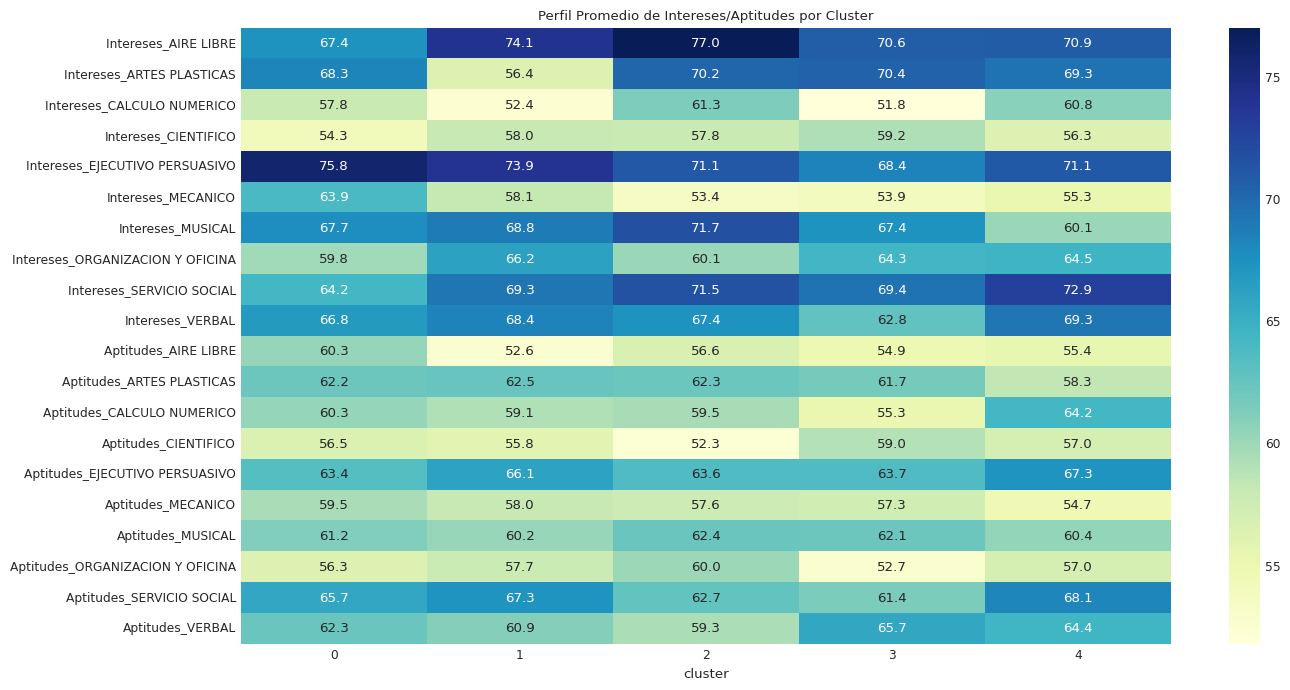

In [15]:
# Aplicar K-Means con 5 clusters
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(pca_df)

# Analizar los clusters
cluster_stats = df.groupby('cluster')[interest_cols + aptitude_cols].mean()

# Visualización y guardado
plt.figure(figsize=(15, 8))
heatmap = sns.heatmap(cluster_stats.T, cmap='YlGnBu', annot=True, fmt='.1f')
plt.title('Perfil Promedio de Intereses/Aptitudes por Cluster')

# Guardar la imagen antes del plt.show()
plt.savefig('cluster_heatmap.png', bbox_inches='tight', dpi=300)
#plt.close()  # Cierra la figura para liberar memoria

# Si aún quieres mostrarla (opcional)
plt.show()

In [16]:
# Calcular porcentajes por cluster
cluster_dist = df['cluster'].value_counts(normalize=True).sort_index() * 100

# Obtener promedios globales para comparación
global_means = df[interest_cols + aptitude_cols].mean()

# Generar reporte automático
for cluster_num in range(5):
    print(f"\n{'='*50}\nCluster {cluster_num} ({cluster_dist[cluster_num]:.1f}% de los estudiantes)\n{'='*50}")
    
    # Variables destacadas (top 5 por diferencia con promedio global)
    cluster_data = cluster_stats.loc[cluster_num]
    top_interests = (cluster_data[interest_cols] - global_means[interest_cols]).sort_values(ascending=False).head(5)
    top_aptitudes = (cluster_data[aptitude_cols] - global_means[aptitude_cols]).sort_values(ascending=False).head(5)
    
    print("\nIntereses más destacados (vs promedio global):")
    for interest, value in top_interests.items():
        print(f"- {interest.replace('Intereses_','')}: {value:+.2f}")
    
    print("\nAptitudes más destacadas (vs promedio global):")
    for aptitude, value in top_aptitudes.items():
        print(f"- {aptitude.replace('Aptitudes_','')}: {value:+.2f}")


Cluster 0 (20.8% de los estudiantes)

Intereses más destacados (vs promedio global):
- MECANICO: +6.96
- EJECUTIVO PERSUASIVO: +3.77
- ARTES PLASTICAS: +1.15
- CALCULO NUMERICO: +0.85
- MUSICAL: +0.62

Aptitudes más destacadas (vs promedio global):
- AIRE LIBRE: +4.19
- MECANICO: +2.06
- ARTES PLASTICAS: +0.81
- SERVICIO SOCIAL: +0.68
- CALCULO NUMERICO: +0.54

Cluster 1 (18.4% de los estudiantes)

Intereses más destacados (vs promedio global):
- ORGANIZACION Y OFICINA: +3.30
- AIRE LIBRE: +2.17
- EJECUTIVO PERSUASIVO: +1.86
- MUSICAL: +1.73
- VERBAL: +1.44

Aptitudes más destacadas (vs promedio global):
- SERVICIO SOCIAL: +2.25
- EJECUTIVO PERSUASIVO: +1.34
- ARTES PLASTICAS: +1.11
- ORGANIZACION Y OFICINA: +0.97
- MECANICO: +0.60

Cluster 2 (20.5% de los estudiantes)

Intereses más destacados (vs promedio global):
- AIRE LIBRE: +5.03
- MUSICAL: +4.58
- CALCULO NUMERICO: +4.33
- ARTES PLASTICAS: +3.09
- SERVICIO SOCIAL: +2.08

Aptitudes más destacadas (vs promedio global):
- ORGANIZA

## Resultados:

## Interpretación Detallada de los 5 Clusters Vocacionales

### Cluster 0: Perfil Técnico-Práctico con Orientación al Aire Libre (20.8%)
**Características destacadas:**
- Fuerte orientación técnica: Mayor interés y aptitud en áreas mecánicas (+6.96 interés, +2.06 aptitud)
- Habilidades ejecutivas: Alto interés persuasivo (+3.77) combinado con aptitud al aire libre (+4.19)
- Perfil equilibrado: Buen balance entre intereses artísticos y numéricos

**Carreras recomendadas:**
1. Ingeniería Mecánica
2. Arquitectura Paisajista
3. Gestión de Proyectos de Construcción
4. Tecnología Agrícola
5. Diseño Industrial

**Potencial desarrollo:** Excelente para roles que combinen trabajo técnico con gestión al aire libre.

---

### Cluster 1: Perfil Organizativo-Social (18.4%)
**Características destacadas:**
- Habilidades organizativas: Mayor interés en organización/oficina (+3.30) y servicio social (+2.25 aptitud)
- Orientación comunicativa: Interés persuasivo (+1.86) y verbal (+1.44)
- Creatividad aplicada: Interés musical (+1.73) y aptitud artística (+1.11)

**Carreras recomendadas:**
1. Administración de Empresas
2. Trabajo Social
3. Recursos Humanos
4. Terapia Ocupacional
5. Gestión Cultural

**Potencial desarrollo:** Ideal para roles de coordinación con componente social y artístico.

---

### Cluster 2: Perfil Científico-Creativo (20.5%)
**Características destacadas:**
- Combinación inusual: Altos intereses científicos (+4.33 cálculo) y creativos (+4.58 musical)
- Orientación práctica: Notable aptitud organizativa (+3.27) e interés al aire libre (+5.03)
- Perfil multidimensional: Destaca en 4 áreas distintas simultáneamente

**Carreras recomendadas:**
1. Ingeniería en Sonido
2. Bioingeniería
3. Diseño de Productos Tecnológicos
4. Ciencias Ambientales
5. Arquitectura

**Potencial desarrollo:** Perfecto para carreras interdisciplinares que integren arte y ciencia.

---

### Cluster 3: Perfil Científico-Verbal (19.6%)
**Características destacadas:**
- Orientación académica: Alto interés científico (+2.13) y aptitud verbal (+3.12)
- Perfil analítico: Combinación de aptitud científica (+2.87) e interés artístico (+3.27)
- Menor interés social: Único cluster con valor negativo en servicio social

**Carreras recomendadas:**
1. Investigación Científica
2. Derecho (especialidades técnicas)
3. Lingüística Computacional
4. Periodismo Científico
5. Filosofía de la Ciencia

**Potencial desarrollo:** Excelente para carreras de investigación y análisis especializado.

---

### Cluster 4: Perfil Matemático-Social (20.7%)
**Características destacadas:**
- Habilidades cuantitativas: Destacado en cálculo numérico (+3.80 interés, +4.48 aptitud)
- Orientación social: Alto interés (+3.42) y aptitud (+3.09) en servicio social
- Comunicación efectiva: Buen balance verbal (+2.34 interés, +1.89 aptitud)

**Carreras recomendadas:**
1. Economía Social
2. Epidemiología
3. Psicometría
4. Estadística Aplicada a Ciencias Sociales
5. Ingeniería en Sistemas Sociales

**Potencial desarrollo:** Ideal para aplicar habilidades matemáticas en contextos sociales.

---

## Análisis Comparativo

**Distribución equilibrada:**
- Todos los clusters representan entre 18-21% de la población
- No existen grupos dominantes

**Patrones cruzados:**
- Clusters 0 y 2: Comparten interés por el aire libre pero difieren en enfoque (técnico vs científico)
- Clusters 3 y 4: Muestran diferentes orientaciones de habilidades numéricas (puro vs social)

**Oportunidades educativas:**
- Cluster 2 (científico-creativo): Beneficiaría de programas interdisciplinares
- Cluster 1 (organizativo-social): Requiere formación en gestión de proyectos creativos

### Visualizacion extra

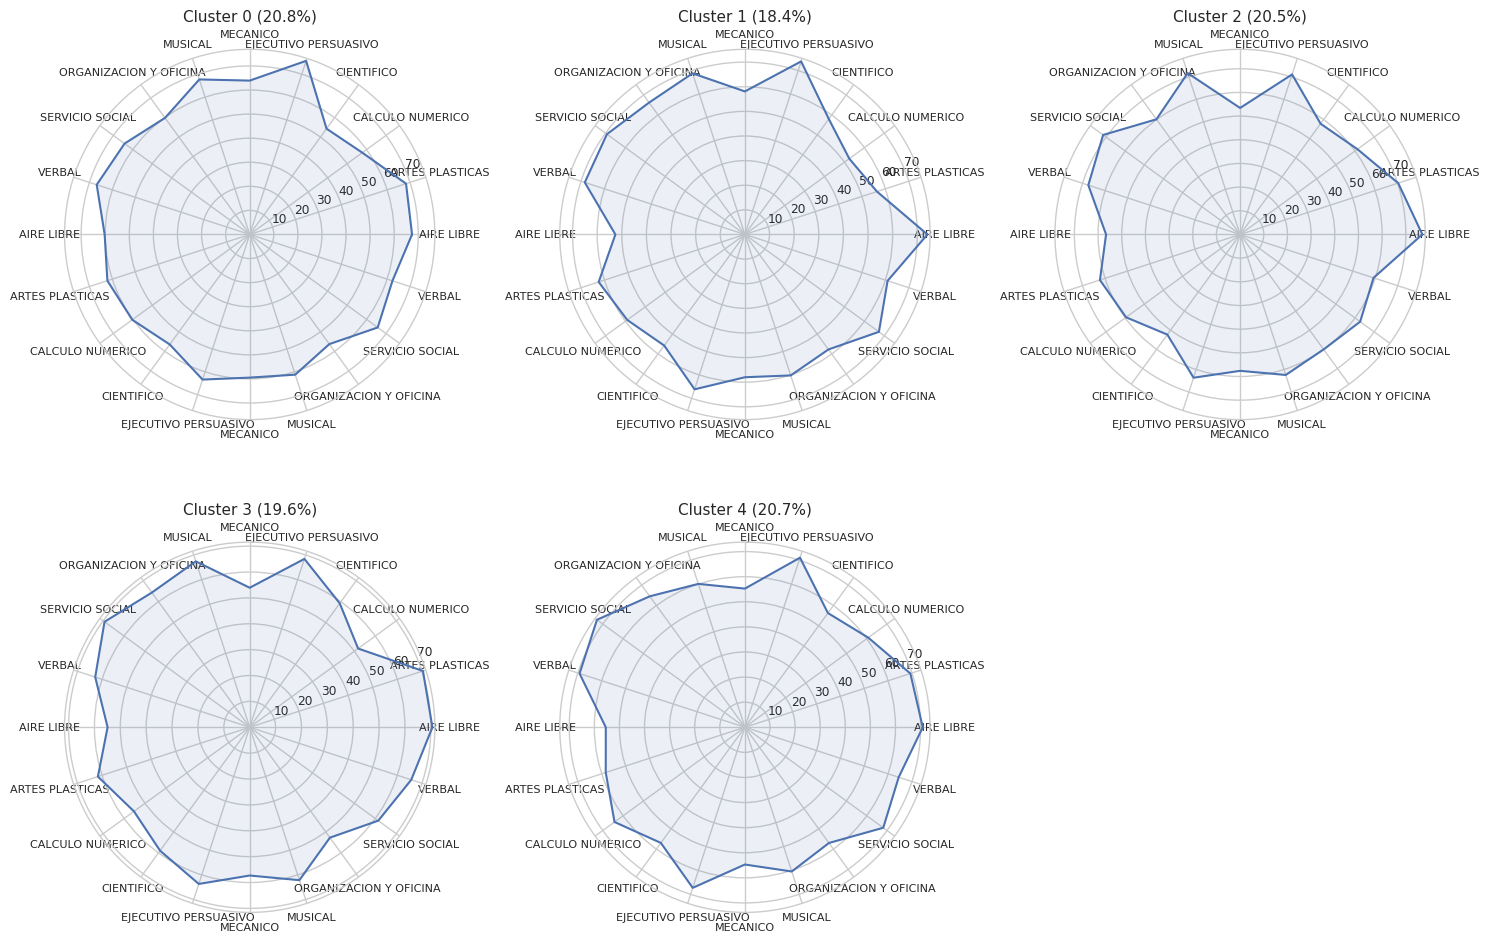

In [18]:
# Gráfico de radar para comparar clusters
from math import pi
import matplotlib.pyplot as plt
import os

# Crear la carpeta si no existe
os.makedirs('images', exist_ok=True)

categories = [col.replace('Intereses_','').replace('Aptitudes_','') for col in interest_cols + aptitude_cols]

fig = plt.figure(figsize=(15, 10))
for cluster_num in range(5):
    values = cluster_stats.loc[cluster_num].values.flatten().tolist()
    values += values[:1]  # Completar el círculo
    
    ax = fig.add_subplot(2, 3, cluster_num+1, polar=True)
    ax.plot([i*2*pi/len(categories) for i in range(len(categories)+1)], values)
    ax.fill([i*2*pi/len(categories) for i in range(len(categories)+1)], values, alpha=0.1)
    ax.set_xticks([i*2*pi/len(categories) for i in range(len(categories))])
    ax.set_xticklabels(categories, size=8)
    ax.set_title(f'Cluster {cluster_num} ({cluster_dist[cluster_num]:.1f}%)', size=11)

plt.tight_layout()

# Guardar la imagen antes de mostrar
plt.savefig('images/radar_clusters.png', 
            bbox_inches='tight', 
            dpi=300, 
            facecolor='white')  # Fondo blanco

# Cerrar la figura para liberar memoria
#plt.close()

# Si deseas verla en el notebook (opcional)
plt.show()

# Relación entre PCA y Clustering: Análisis Integrado

## Conexión entre Componentes Principales y Clusters

La relación entre los componentes principales (PCA) y los clusters obtenidos es fundamental para entender cómo se complementan estos dos análisis.

## 1. Fundamentos Conceptuales

### PCA (Análisis de Componentes Principales)
- **Identifica** direcciones de máxima variación en los datos  
- **Reduce dimensionalidad** creando nuevas variables (componentes) no correlacionadas  
- Cada PC es una **combinación lineal ponderada** de las variables originales  

### Clusterización (K-Means)
- **Agrupa** casos similares basándose en sus características  
- **Identifica** patrones naturales de agrupación en los datos  
- Trabaja mejor en **espacios de baja dimensionalidad** (por eso usamos los PCs)  

## 2. Relación en Nuestro Análisis

### Validación Cruzada
Los clusters reflejan combinaciones coherentes de los componentes PCA:

#### Cluster 0 (Técnico-Práctico)
- **Componentes relacionados**:
  - PC3 (Organizativo-Técnico): +0.431 Mecánico  
  - PC4 (Aire Libre): +0.440  
- **Validación**: El PCA ya identificó esta combinación técnico-externa como patrón subyacente  

#### Cluster 3 (Científico-Verbal)
- **Componentes relacionados**:
  - PC1 (Científico-Social-Verbal): +0.377 Verbal  
  - PC9 (Científico Puro): +0.460 Científico  
- **Validación**: Corrobora la dimensión ciencia+verbal prevista  

#### Cluster 4 (Matemático-Social)
- **Componentes relacionados**:
  - PC1 (Científico-Social): Componente social (+0.395) y numérico (+0.485)  
  - PC10 (Social-Ambiental): +0.447 Servicio social  
- **Validación**: Confirma esta dualidad detectada en PCA  

### Patrones Confirmados

| Componente PCA              | Cluster Relacionado | Relación Confirmada               |
|-----------------------------|---------------------|-----------------------------------|
| PC1 (Científico-Social-Verbal) | Cluster 4           | Matemáticas + servicio social     |
| PC3 (Organizativo-Técnico)     | Cluster 0           | Mecánica + organización           |
| PC6 (Artístico-Verbal)         | Cluster 2           | Arte + música + verbal            |
| PC8 (Musical Conflictivo)      | Cluster 2           | Alta presencia musical            |
| PC10 (Social-Ambiental)        | Cluster 1           | Servicio social + aire libre      |

## 3. Discrepancias y Complementariedad

### PC5 (Ejecutivo-Comunicativo)
- **Distribución**:
  - Cluster 0 (parcialmente)  
  - Cluster 1 (parcialmente)  
- **Insight**: El perfil ejecutivo no forma un grupo puro, sino que se integra con otros  

### PC7 (Organizativo-Artístico)
- **División**:
  - Cluster 1 (organizativo)  
  - Cluster 2 (artístico)  
- **Insight**: Confirma que son perfiles distintos, no un continuo  

<div style="background-color: #f5f5f5; padding: 15px; border-left: 4px solid #2196F3;">
<strong>Conclusión:</strong> La combinación de PCA y clustering permite identificar tanto las dimensiones subyacentes como los perfiles concretos en los datos, ofreciendo una visión completa para el sistema de recomendación vocacional.
</div>

## Sistema de Recomendación Vocacional Basado en PCA y Clustering

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import joblib

# Cargar modelos y datos
try:
    pca = joblib.load('pca_model.pkl')
    kmeans = joblib.load('kmeans_model.pkl')
    scaler = joblib.load('scaler.pkl')
except:
    # Si no existen, entrenarlos (ejecutar solo una vez)
    from sklearn.decomposition import PCA
    from sklearn.cluster import KMeans
    
    # Cargar datos
    df = pd.read_excel('datos_completos_con_puntuaciones_escaladas.xlsx')
    
    # Seleccionar columnas de interés
    interest_cols = [col for col in df.columns if col.startswith('Intereses_')]
    aptitude_cols = [col for col in df.columns if col.startswith('Aptitudes_')]
    
    # Estandarizar datos
    scaler = StandardScaler()
    X_std = scaler.fit_transform(df[interest_cols + aptitude_cols])
    
    # Entrenar PCA
    pca = PCA(n_components=10)
    pca_scores = pca.fit_transform(X_std)
    
    # Entrenar K-Means
    kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
    df['cluster'] = kmeans.fit_predict(pca_scores)
    
    # Guardar modelos
    joblib.dump(pca, 'pca_model.pkl')
    joblib.dump(kmeans, 'kmeans_model.pkl')
    joblib.dump(scaler, 'scaler.pkl')

# Definir diccionario de carreras por cluster (basado en análisis previo)
career_recommendations = {
    0: ["Ingeniería Mecánica", "Arquitectura Paisajista", "Gestión de Proyectos de Construcción", "Tecnología Agrícola", "Diseño Industrial"],
    1: ["Administración de Empresas", "Trabajo Social", "Recursos Humanos", "Terapia Ocupacional", "Gestión Cultural"],
    2: ["Ingeniería en Sonido", "Bioingeniería", "Diseño de Productos Tecnológicos", "Ciencias Ambientales", "Arquitectura"],
    3: ["Investigación Científica", "Derecho (especialidades técnicas)", "Lingüística Computacional", "Periodismo Científico", "Filosofía de la Ciencia"],
    4: ["Economía Social", "Epidemiología", "Psicometría", "Estadística Aplicada a Ciencias Sociales", "Ingeniería en Sistemas Sociales"]
}

# Función para hacer recomendaciones
def recommend_vocation(student_id=None, student_data=None):
    """
    Recibe:
    - student_id: ID del estudiante en el DataFrame
    - student_data: Diccionario con datos si no está en el DataFrame
    
    Retorna:
    - Diccionario con análisis completo
    """
    # Cargar datos si no se proporcionan
    if student_data is None:
        df = pd.read_excel('datos_completos_con_puntuaciones_escaladas.xlsx')
        student = df[df['ID'] == student_id].iloc[0]
    else:
        student = pd.Series(student_data)
    
    # Preparar datos
    interest_aptitude = student[[*interest_cols, *aptitude_cols]].values.reshape(1, -1)
    
    # Transformar datos
    X_std = scaler.transform(interest_aptitude)
    pca_scores = pca.transform(X_std)
    cluster = kmeans.predict(pca_scores)[0]
    
    # Obtener componentes principales más relevantes
    top_components = np.argsort(np.abs(pca_scores[0]))[::-1][:3]  # Top 3 componentes
    
    # Interpretación de componentes
    component_descriptions = {
        0: "Científico-Social-Verbal (Habilidades cuantitativas con intereses sociales y verbales)",
        1: "Social vs Técnico-Práctico (Orientación al servicio vs intereses técnicos)",
        2: "Organizativo-Técnico (Habilidades técnicas con capacidad organizativa)",
        3: "Aire Libre vs Artístico (Preferencia por actividades externas vs talleres)",
        4: "Ejecutivo-Comunicativo (Habilidades de liderazgo y comunicación)",
        5: "Artístico-Verbal (Combinación de habilidades artísticas y lingüísticas)",
        6: "Organizativo-Artístico (Perfil sistemático con intereses creativos)",
        7: "Musical (Orientación a actividades musicales)",
        8: "Científico Puro (Interés en investigación teórica)",
        9: "Social-Ambiental (Orientación al servicio comunitario y naturaleza)"
    }
    
    # Resultados
    result = {
        "ID": student.get('ID', 'N/A'),
        "Nombre": f"{student.get('Nombres', '')} {student.get('Apellido Paterno', '')}",
        "Cluster": int(cluster),
        "Componentes_Principales": [
            {
                "PC": f"PC{comp+1}",
                "Score": float(pca_scores[0, comp]),
                "Interpretacion": component_descriptions[comp]
            } for comp in top_components
        ],
        "Carreras_Recomendadas": career_recommendations[cluster],
        "Variables_Destacadas": {
            "Intereses": dict(student[interest_cols].sort_values(ascending=False).head(3)),
            "Aptitudes": dict(student[aptitude_cols].sort_values(ascending=False).head(3))
        }
    }
    
    return result

## 2. Cómo Usar el Sistema

### Consultar por ID existente
# Ejemplo con ID existente
resultado = recommend_vocation(student_id=15)

In [ ]:
print(resultado)

## Interfaz de usuario 

In [ ]:
def interactive_recommendation():
    print("\n=== Sistema de Recomendación Vocacional ===")
    option = input("¿Desea buscar por ID (1) o ingresar datos manualmente (2)? ")
    
    if option == '1':
        student_id = int(input("Ingrese el ID del estudiante: "))
        result = recommend_vocation(student_id=student_id)
    else:
        print("\nIngrese las puntuaciones (0-100) para cada variable:")
        student_data = {}
        for col in [*interest_cols, *aptitude_cols]:
            student_data[col] = float(input(f"{col}: "))
        result = recommend_vocation(student_data=student_data)
    
    # Mostrar resultados
    print("\n=== RESULTADOS ===")
    print(f"Estudiante: {result['Nombre']}")
    print(f"Cluster asignado: {result['Cluster']}")
    
    print("\nComponentes principales más relevantes:")
    for comp in result['Componentes_Principales']:
        print(f"- {comp['PC']}: {comp['Interpretacion']} (Score: {comp['Score']:.2f})")
    
    print("\nCarreras recomendadas:")
    for i, carrera in enumerate(result['Carreras_Recomendadas'], 1):
        print(f"{i}. {carrera}")
    
    print("\nVariables más destacadas:")
    print("Intereses:")
    for k, v in result['Variables_Destacadas']['Intereses'].items():
        print(f"- {k.replace('Intereses_', '')}: {v}")
    
    print("\nAptitudes:")
    for k, v in result['Variables_Destacadas']['Aptitudes'].items():
        print(f"- {k.replace('Aptitudes_', '')}: {v}")

# Ejecutar interfaz
interactive_recommendation()

In [ ]:
### Creación de requirements

In [ ]:
# Celda AUTOCONTAINED (incluyendo Python version)
import sys
import pandas as pd
import numpy as np
import matplotlib as matplotlib
import seaborn as sns
from scipy import __version__ as scipy_version
from sklearn import __version__ as sklearn_version
from joblib import __version__ as joblib_version

with open('requirements.txt', 'w') as f:
    f.write(f"python=={sys.version_info.major}.{sys.version_info.minor}.{sys.version_info.micro}\n")  # Ej: python==3.9.12
    f.write(f"pandas>={pd.__version__}\n")
    f.write(f"numpy>={np.__version__}\n")
    f.write(f"matplotlib>={matplotlib.__version__}\n")
    f.write(f"seaborn>={sns.__version__}\n")
    f.write(f"scipy>={scipy_version}\n")
    f.write(f"scikit-learn>={sklearn_version}\n")
    f.write(f"joblib>={joblib_version}\n")

print("✅ requirements.txt generado con versión de Python!")